## Topic Diversity evaluation
**Intuition**: The clusters should be located as far away from each other as possible. Therefore, an evaluation metric of topic diversity can be calculated by evaluating the distance between topic cluster centroids. Finding the average of the minimum distance for each topic to another and maximising this value over different model configurations could yeild high quality topics. 

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Helper functions

def topic_diversity_dataframe(topic_model, model_call=False):
    """
    Make dataframe appropriate for evaluation of topic centroid embeddings.
    topic_model: insert topic model which is generated from the bertopic library.
    model call: set to True if called from another function.
    """
    topic_embeddings = topic_model.topic_embeddings_
    topic_labels = topic_model.topic_labels_.values()

    dis_matrix = cosine_distances(topic_embeddings)
    df_dis = pd.DataFrame(dis_matrix, columns=topic_labels, index=topic_labels)

    # Convert cosine distance matrix to pair-wise dataframe
    triangular_matrix = pd.DataFrame(np.triu(df_dis), columns=df_dis.columns, index=df_dis.columns)
    df_long = triangular_matrix.stack().reset_index()
    df_long.columns = ['pair_1', 'pair_2', 'cosine_distance'] # Rename columns
    df_long = df_long[df_long.cosine_distance !=0] # Remove rows with 0 cosine distance
    # print('Dataframe shape:', df_long.shape)
    if model_call == False:
        return df_long
    else:
        return df_long.groupby("pair_1")["cosine_distance"].min()


def plot_topic_diversity(topic_model, umap_metric='cosine', text_height=20):
    """
    Plot topic diversity metrics. 
    topic_model: insert topic model which is generated from the bertopic library. 
    umap_metric: which similarity metric to use for UMAP dim reduction
    text_hight: regulate the y position of the mean number
    """
    # Manipulate data for plotting
    min_edges = topic_diversity_dataframe(topic_model, model_call=True)
    mapper = umap.UMAP(n_components=2, metric=umap_metric, random_state=42).fit_transform(topic_model.topic_embeddings_)

    # Plot topic diversity metric
    fig, axs = plt.subplots(1,2, figsize=(12, 5))

    # Plot min edge weight distribution
    sns.histplot(x=min_edges.values, kde=True, bins=20, ax=axs[0])
    axs[0].axvline(np.mean(min_edges.values), color="r", label="Mean")
    axs[0].set_title("Topic Diversity Distribution")
    axs[0].set_xlabel("Cosine distance to closest topic centroid")
    axs[0].text(x=np.mean(min_edges.values)+0.01, y=text_height, s=f"{np.mean(min_edges.values):.3}")
    axs[0].legend()

    # Plot dim reduce topic embeddings 
    plt.scatter(mapper[:,0], mapper[:,1])
    axs[1].set_title("Topic embeddings when reduced from 384 to 2 dims")
    axs[1].set_xlabel("Topic centroid pos. dim_1")
    axs[1].set_ylabel("Topic centroid pos. dim_2")
    plt.show()


def topics_describe(topic_model, name='model', make_plot=True):
    """
    Provide descriptive stats about the model:
    1. Clusters
        a) topic diversity score
        b) number of clusters
        c) unclusterd documents and their proportion
        d) Size of clusters - Min, Max, Mean
    2. Distribution of cluster size plot
    topic_model: insert topic model which is generated from the bertopic library. 
    name: index for dataframe
    make_plot: if False, skip point 2 above.
    """
    topic_freq = topic_model.get_topic_freq()
    min_edges = topic_diversity_dataframe(topic_model, model_call=True)
    topic_diversity_score = np.mean(min_edges.values)
    desc_stats = pd.DataFrame({"topic_diversity_score": [topic_diversity_score],
                               "cluster_count": [len(topic_freq)-1], 
                               "unclustered_docs_count": [topic_freq.Count[0]],
                               "unclustered_docs_prop": [topic_freq.Count[0]/topic_freq.Count.sum()],
                               "max_cluster_size": [max(topic_freq.Count[1:])],
                               "min_cluster_size": [min(topic_freq.Count[1:])],
                               "mean_cluster_size": [np.mean(topic_freq.Count[1:])]}, index=[name])
    # plot dist
    if make_plot == True:
        sns.barplot(x=topic_freq.Topic[1:], y=topic_freq.Count[1:])
        plt.title("Distribution of cluster size")
        plt.ylabel("Documents in cluster")
        plt.show()

    return desc_stats



## BERT v1

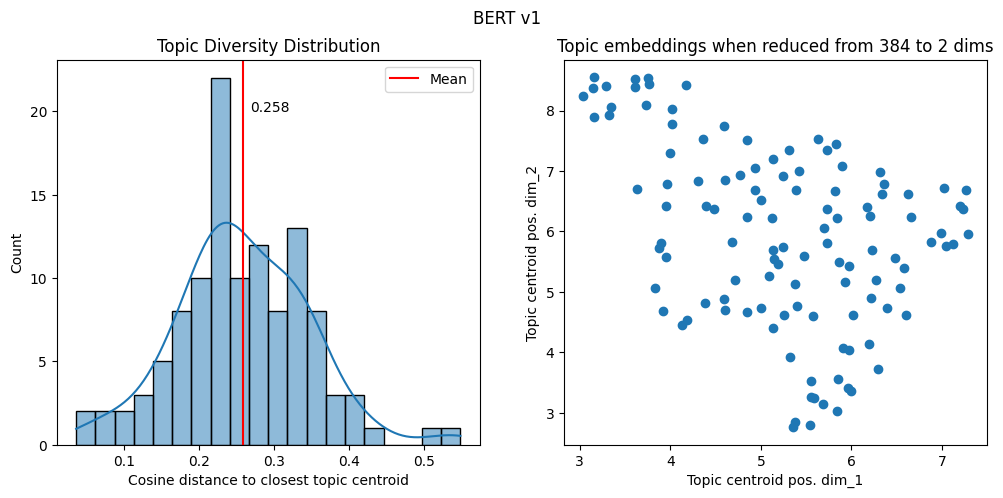

In [6]:
# Load model 
bert_v1 = BERTopic.load("BERT_v1")

plot_topic_diversity(bert_v1)

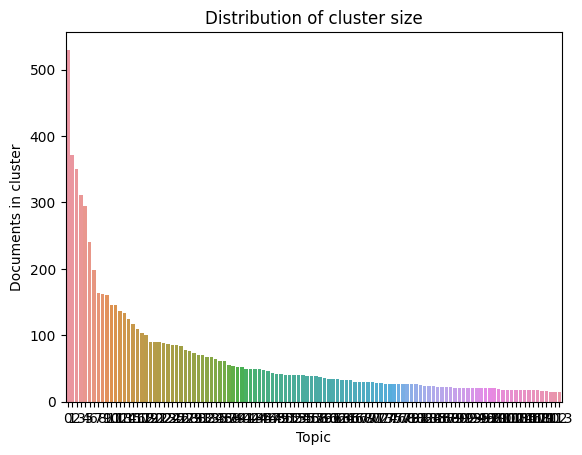

,topic_diversity_score,cluster_count,unclustered_docs_count,unclustered_docs_prop,max_cluster_size,min_cluster_size,mean_cluster_size
bert_v1,0.258068,114,7432,0.495467,530,15,66.385965


In [4]:
topics_describe(bert_v1, name="bert_v1", make_plot=True)

## BERT V2

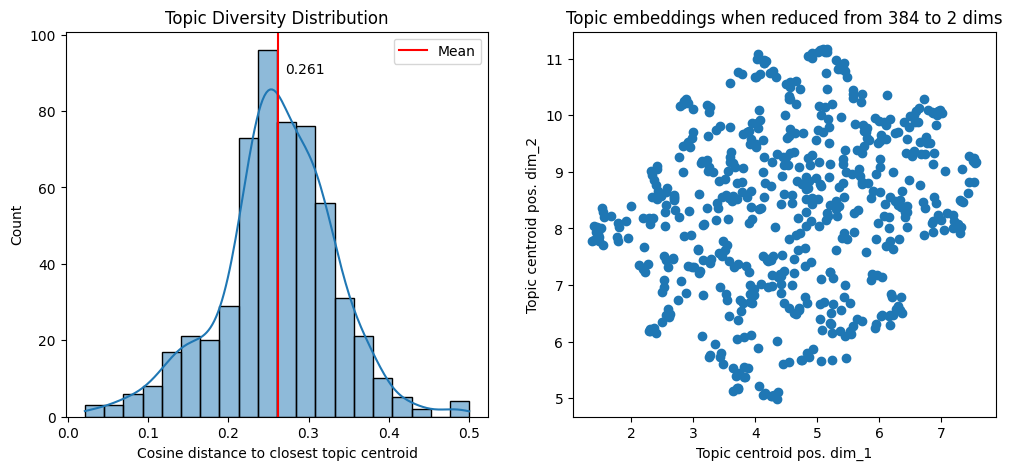

In [15]:
bert_v2 = BERTopic.load('BERT_v2')
plot_topic_diversity(bert_v2, text_height=90)

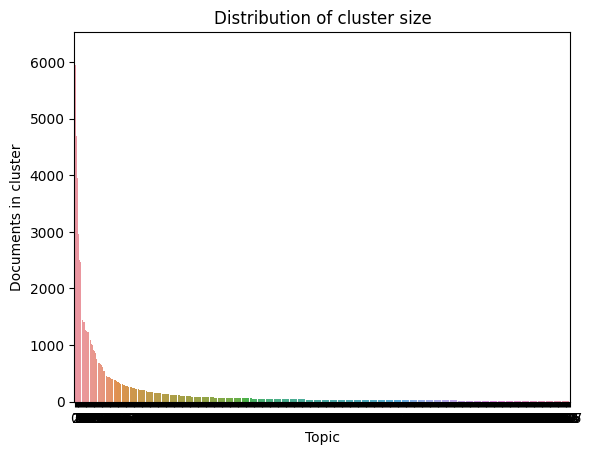

,topic_diversity_score,cluster_count,unclustered_docs_count,unclustered_docs_prop,max_cluster_size,min_cluster_size,mean_cluster_size
model,0.261331,558,125515,0.575445,6217,15,165.955197


In [5]:
topics_describe(bert_v2)

In [13]:
v1 = topics_describe(bert_v1, make_plot=False, name="bert_v1")
v2 = topics_describe(bert_v2, make_plot=False, name="bert_v2")
pd.concat([v1, v2], axis=0)

,topic_diversity_score,cluster_count,unclustered_docs_count,unclustered_docs_prop,max_cluster_size,min_cluster_size,mean_cluster_size
bert_v1,0.258068,114,7432,0.495467,530,15,66.385965
bert_v2,0.261331,558,125515,0.575445,6217,15,165.955197
